# Prepare synthetic survey data for the assessment

In [1]:
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import verde as vd
import harmonica as hm
import boule as bl
import pyproj

In [2]:
random = np.random.default_rng(seed=100)

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load the Southern Africa gravity data

In [3]:
data = hm.datasets.fetch_south_africa_gravity()
data = data[data.elevation > 0]
data

,latitude,longitude,elevation,gravity
43,-34.12971,18.34444,32.2,979656.12
44,-34.08833,18.36028,592.5,979508.21
45,-34.19583,18.37418,18.4,979666.46
47,-34.23972,18.40388,25.0,979671.03
48,-34.16444,18.41112,228.7,979616.11
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


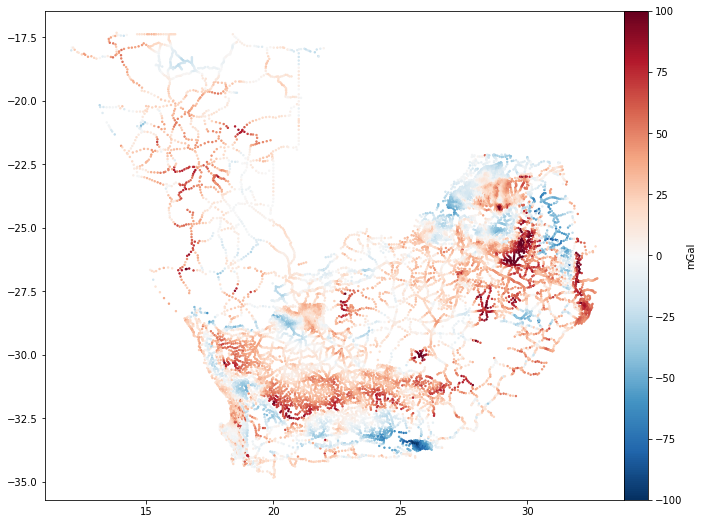

In [4]:
plt.figure(figsize=(14, 9))
plt.scatter(data.longitude, data.latitude, c=data.gravity - bl.WGS84.normal_gravity(data.latitude, data.elevation), s=2, vmin=-100, vmax=100, cmap="RdBu_r")
plt.axis("scaled")
plt.colorbar(pad=0, label="mGal")

## Select a smaller survey area

In [5]:
region = [26.5, 31, -26, -24]
projection = pyproj.Proj("+proj=utm +zone=34H +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
survey = data.loc[vd.inside((data.longitude, data.latitude), region)][::5].copy().reset_index(drop=True)
survey["station_id"] = np.arange(survey.shape[0])
survey["easting"], survey["northing"] = (np.round(i, decimals=2) for i in projection(survey.longitude.values, survey.latitude.values))
survey

,latitude,longitude,elevation,gravity,station_id,easting,northing
0,-25.42709,26.50162,1088.00,978635.98,0,1053773.17,7176320.94
1,-25.84332,26.52499,1544.71,978575.41,1,1054195.48,7129995.60
2,-25.34309,26.58333,1065.00,978637.75,2,1062405.25,7185307.41
3,-25.49702,26.60262,1195.00,978616.00,3,1063632.30,7168128.50
4,-25.84000,26.61333,1513.93,978585.91,4,1063089.97,7129986.96
...,...,...,...,...,...,...,...
309,-24.85333,30.57500,1220.41,978562.82,309,1470291.75,7217002.85
310,-24.00999,30.67667,487.37,978678.88,310,1487306.65,7310523.65
311,-24.15833,30.83000,450.79,978702.07,311,1501880.60,7292835.71
312,-24.93167,30.84332,1440.17,978528.62,312,1497014.44,7206277.07


/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


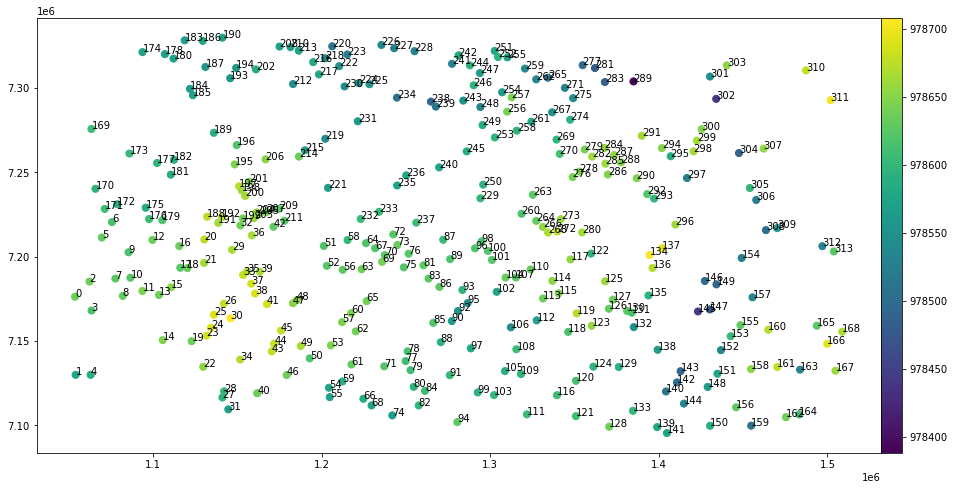

In [6]:
plt.figure(figsize=(18, 8))
ax = plt.subplot(111)
tmp = ax.scatter(survey.easting, survey.northing, c=survey.gravity, s=50)
for i in range(survey.shape[0]):
    ax.text(survey.easting[i], survey.northing[i], str(survey.station_id[i]))
plt.axis("scaled")
plt.colorbar(tmp, pad=0)

## Split this up into daily surveys

Each of these will represent a day in the field, starting and ending at a base station for drift correction.

In [7]:
nsurveys = 15
bases = [
    31, 31, 31, 31, 141, 141, 141, 141,
    212, 212, 212, 212, 301, 301, 301,
]
assert len(bases) == nsurveys
# Made up number for the reading scaling
base_readings = random.uniform(1630, 2200, size=nsurveys)
base_gravities = [survey.gravity[base] for base in bases]
sections = np.array_split(survey.station_id, nsurveys)
survey_stations = []
for base, section in zip(bases, sections):
    section = section[section != base]
    survey_stations.append(np.concatenate([[base], section, [base]]))
survey_stations

[array([31,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 31]),
 array([31, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 31]),
 array([31, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 31]),
 array([31, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 81, 82, 83, 31]),
 array([141,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 141]),
 array([141, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 141]),
 array([141, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 142, 143, 144, 145, 146, 141]),
 array([141, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 141]),
 array([212, 168, 169, 170, 171, 172,

In [8]:
surveys = [survey.iloc[stations].copy().reset_index(drop=True) for stations in survey_stations]
surveys[-1]

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,elevation,gravity,station_id,easting,northing
0,-24.07668,30.12666,1084.00,978547.04,301,1430372.28,7306880.44
1,-24.47197,29.87583,907.00,978649.39,294,1401830.58,7264425.30
2,-24.51167,29.92999,1075.32,978587.81,295,1407074.24,7259635.25
3,-24.87167,29.98334,1016.50,978661.49,296,1409868.69,7219096.27
4,-24.62117,30.03250,1554.00,978526.09,297,1416735.54,7246725.07
5,-24.47833,30.06000,848.86,978665.29,298,1420598.48,7262485.16
6,-24.42000,30.07500,766.87,978663.59,299,1422561.63,7268895.91
7,-24.35834,30.09833,707.13,978648.39,300,1425401.85,7275622.45
8,-24.19250,30.17084,1625.00,978443.25,302,1434047.93,7293649.25
9,-24.01167,30.21918,628.00,978652.16,303,1440338.43,7313515.89


/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


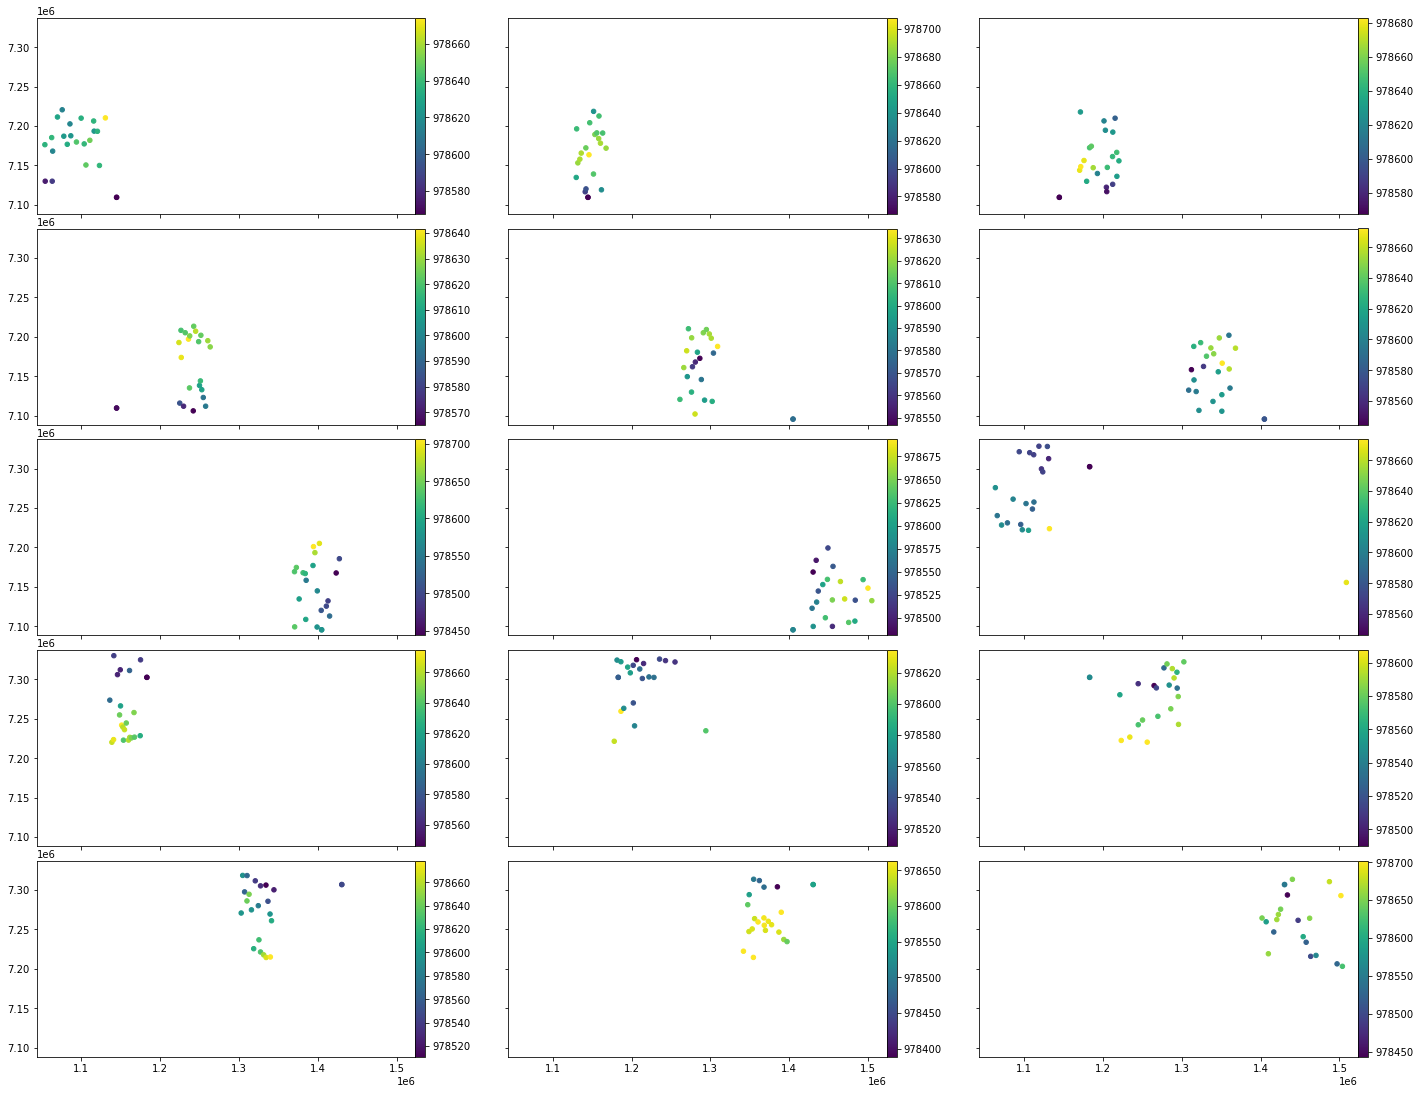

In [9]:
fig, axes = plt.subplots(5, len(surveys) // 5, figsize=(20, 15), sharey=True, sharex=True)
for s, ax in zip(surveys, axes.ravel()):
    tmp = ax.scatter(s.easting, s.northing, c=s.gravity, s=20)
    ax.set_aspect("equal")
    ax.set_xlim(survey.easting.min()*0.99, survey.easting.max()*1.01)
    ax.set_ylim(survey.northing.min()*0.999, survey.northing.max()*1.001)
    plt.colorbar(tmp, pad=0, ax=ax, orientation="vertical")
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

## Convert the gravity values to relative readings

Subtract from the base station gravity and add a factor so that it's around 2500 (rough range for latitude of -30). The factor should vary from day to day by a small factor.

In [10]:
for s, base_reading, base_gravity in zip(surveys, base_readings, base_gravities):
    s["reading_mgal"] = s.gravity - base_gravity + base_reading
surveys[-1]

,latitude,longitude,elevation,gravity,station_id,easting,northing,reading_mgal
0,-24.07668,30.12666,1084.00,978547.04,301,1430372.28,7306880.44,1971.949996
1,-24.47197,29.87583,907.00,978649.39,294,1401830.58,7264425.30,2074.299996
2,-24.51167,29.92999,1075.32,978587.81,295,1407074.24,7259635.25,2012.719996
3,-24.87167,29.98334,1016.50,978661.49,296,1409868.69,7219096.27,2086.399996
4,-24.62117,30.03250,1554.00,978526.09,297,1416735.54,7246725.07,1950.999996
5,-24.47833,30.06000,848.86,978665.29,298,1420598.48,7262485.16,2090.199996
6,-24.42000,30.07500,766.87,978663.59,299,1422561.63,7268895.91,2088.499996
7,-24.35834,30.09833,707.13,978648.39,300,1425401.85,7275622.45,2073.299996
8,-24.19250,30.17084,1625.00,978443.25,302,1434047.93,7293649.25,1868.159996
9,-24.01167,30.21918,628.00,978652.16,303,1440338.43,7313515.89,2077.069996


/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


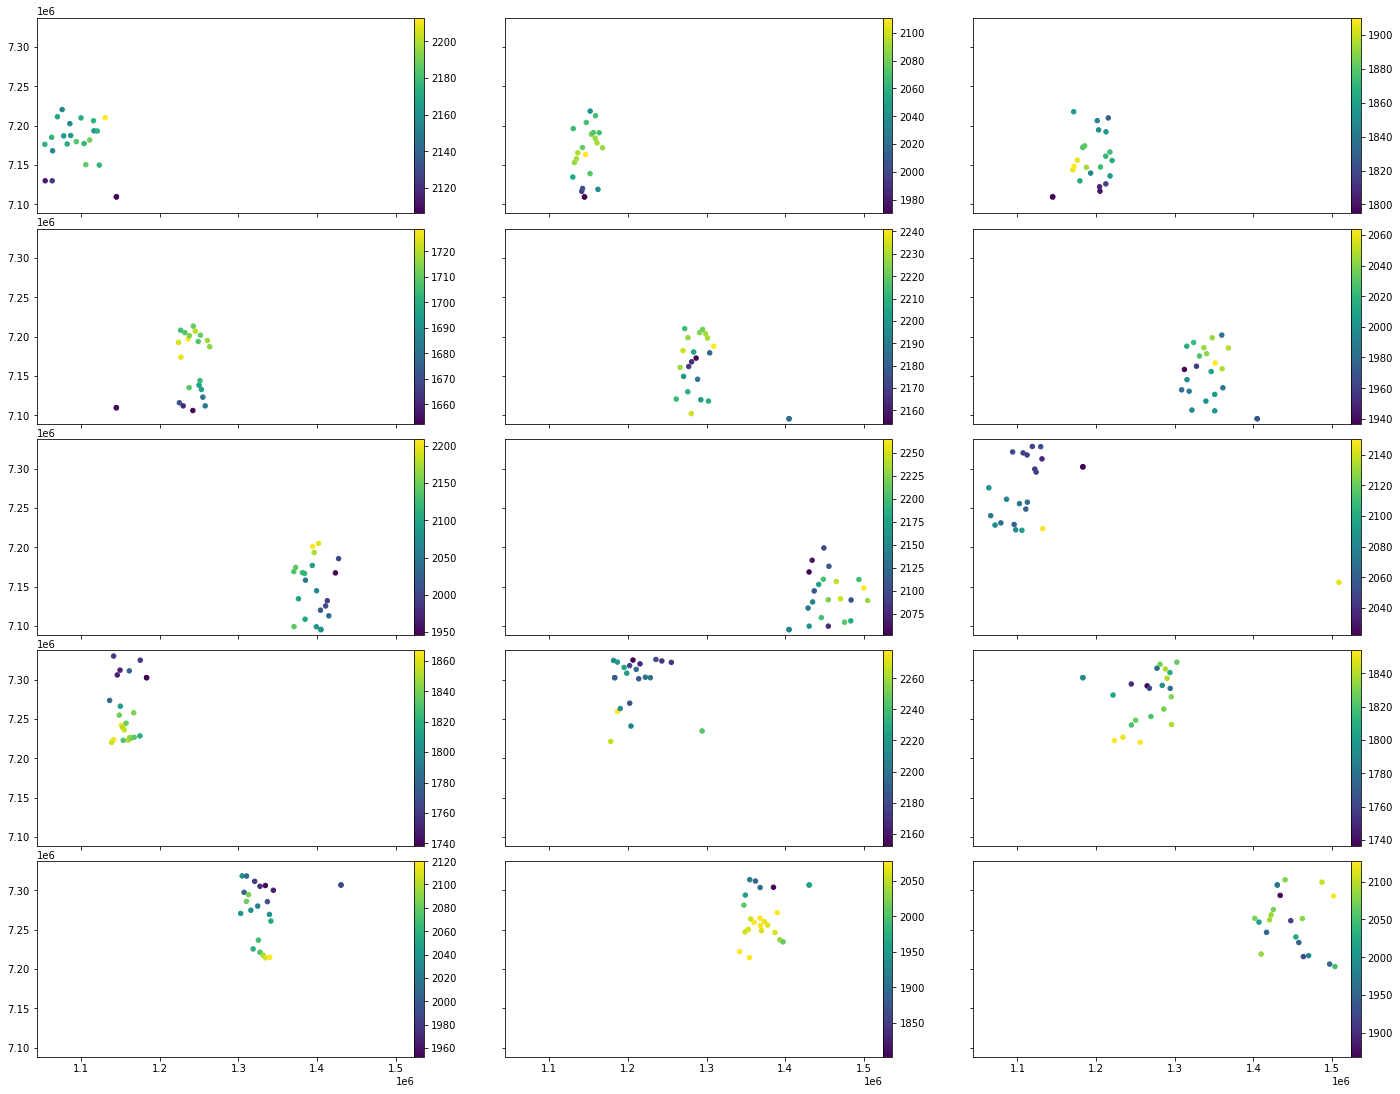

In [11]:
fig, axes = plt.subplots(5, len(surveys) // 5, figsize=(20, 15), sharey=True, sharex=True)
for s, ax in zip(surveys, axes.ravel()):
    tmp = ax.scatter(s.easting, s.northing, c=s.reading_mgal, s=20)
    ax.set_aspect("equal")
    ax.set_xlim(survey.easting.min()*0.99, survey.easting.max()*1.01)
    ax.set_ylim(survey.northing.min()*0.999, survey.northing.max()*1.001)
    plt.colorbar(tmp, pad=0, ax=ax, orientation="vertical")
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

## Convert readings from mGal to L&G gravimeter scale divisions


Use a conversion table for the gravimeter. 

In [12]:
conversion = pd.read_csv("../data/gravimeter-scaling.csv", index_col="counter_reading")
conversion

,value_mgal,interval_factor
counter_reading,,
0,0.00,1.00636
100,100.64,1.00621
200,201.26,1.00609
300,301.87,1.00597
400,402.46,1.00588
...,...,...
6600,6632.04,1.00154
6700,6732.20,1.00123
6800,6832.32,1.00089


In [13]:
for s in surveys:
    interval = np.floor(s.reading_mgal / 100).astype("int") * 100
    conv = conversion.loc[interval]
    s["reading_nodrift"] = interval + (s.reading_mgal - conv.value_mgal.values) / conv.interval_factor.values
surveys[-1]

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,elevation,gravity,station_id,easting,northing,reading_mgal,reading_nodrift
0,-24.07668,30.12666,1084.00,978547.04,301,1430372.28,7306880.44,1971.949996,1961.013943
1,-24.47197,29.87583,907.00,978649.39,294,1401830.58,7264425.30,2074.299996,2062.833888
2,-24.51167,29.92999,1075.32,978587.81,295,1407074.24,7259635.25,2012.719996,2001.571838
3,-24.87167,29.98334,1016.50,978661.49,296,1409868.69,7219096.27,2086.399996,2074.871413
4,-24.62117,30.03250,1554.00,978526.09,297,1416735.54,7246725.07,1950.999996,1940.171905
5,-24.47833,30.06000,848.86,978665.29,298,1420598.48,7262485.16,2090.199996,2078.651793
6,-24.42000,30.07500,766.87,978663.59,299,1422561.63,7268895.91,2088.499996,2076.960570
7,-24.35834,30.09833,707.13,978648.39,300,1425401.85,7275622.45,2073.299996,2061.839051
8,-24.19250,30.17084,1625.00,978443.25,302,1434047.93,7293649.25,1868.159996,1857.760795
9,-24.01167,30.21918,628.00,978652.16,303,1440338.43,7313515.89,2077.069996,2065.589586


## Add an acquisiton time to the survey

Record time as ellapsed minutes since the first measurement.

In [14]:
for s in surveys:
    distance = np.hypot(s.easting.values[1:] - s.easting.values[:-1], s.northing.values[1:] - s.northing.values[:-1]) * 1e-3
    # Randomize the velocity between sites to make things less uniform
    velocity = random.uniform(low=60, high=80, size=distance.size)
    travel_time = np.concatenate([[0], np.round((distance / velocity) * 60, decimals=0)])
    s["time_minutes"] = np.cumsum(travel_time)
surveys[1]

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,elevation,gravity,station_id,easting,northing,reading_mgal,reading_nodrift,time_minutes
0,-25.99001,27.43333,1587.99,978567.41,31,1144726.82,7109516.68,1970.035795,1959.109608,0.0
1,-25.21667,27.25000,1131.10,978662.69,21,1130376.64,7196373.38,2065.315795,2053.896075,75.0
2,-25.77000,27.27333,1193.59,978651.19,22,1129825.43,7134756.48,2053.815795,2042.455452,127.0
3,-25.60333,27.28500,1103.98,978686.28,23,1131884.49,7153227.02,2088.905795,2077.364275,144.0
4,-25.56000,27.30833,1091.48,978690.28,24,1134465.95,7157931.52,2092.905795,2081.343622,148.0
5,-25.49001,27.32167,1074.41,978690.88,25,1136182.50,7165647.63,2093.505795,2081.940524,155.0
6,-25.42833,27.37666,1110.38,978675.68,26,1142060.29,7172238.98,2078.305795,2066.819005,163.0
7,-25.92833,27.39500,1485.89,978594.71,27,1141212.03,7116563.50,1997.335795,1986.268922,206.0
8,-25.89500,27.40334,1464.86,978602.50,28,1142232.15,7120227.78,2005.125795,1994.016848,209.0
9,-25.14000,27.41000,1053.68,978665.89,29,1146964.36,7204132.57,2068.515795,2057.079552,283.0


## Apply fake drift correction to readings

Generate a slightly different one for each day.

In [15]:
for s in surveys:
    drift = np.round(random.uniform(0.01, 0.05), decimals=2)
    s["reading"] = np.round(s.reading_nodrift + drift * s.time_minutes, decimals=2)
    assert np.allclose(drift, (s.reading.iloc[-1] - s.reading.iloc[0]) / s.time_minutes.iloc[-1])
surveys[-1]

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,elevation,gravity,station_id,easting,northing,reading_mgal,reading_nodrift,time_minutes,reading
0,-24.07668,30.12666,1084.00,978547.04,301,1430372.28,7306880.44,1971.949996,1961.013943,0.0,1961.01
1,-24.47197,29.87583,907.00,978649.39,294,1401830.58,7264425.30,2074.299996,2062.833888,45.0,2064.63
2,-24.51167,29.92999,1075.32,978587.81,295,1407074.24,7259635.25,2012.719996,2001.571838,50.0,2003.57
3,-24.87167,29.98334,1016.50,978661.49,296,1409868.69,7219096.27,2086.399996,2074.871413,83.0,2078.19
4,-24.62117,30.03250,1554.00,978526.09,297,1416735.54,7246725.07,1950.999996,1940.171905,108.0,1944.49
5,-24.47833,30.06000,848.86,978665.29,298,1420598.48,7262485.16,2090.199996,2078.651793,123.0,2083.57
6,-24.42000,30.07500,766.87,978663.59,299,1422561.63,7268895.91,2088.499996,2076.960570,128.0,2082.08
7,-24.35834,30.09833,707.13,978648.39,300,1425401.85,7275622.45,2073.299996,2061.839051,134.0,2067.20
8,-24.19250,30.17084,1625.00,978443.25,302,1434047.93,7293649.25,1868.159996,1857.760795,150.0,1863.76
9,-24.01167,30.21918,628.00,978652.16,303,1440338.43,7313515.89,2077.069996,2065.589586,170.0,2072.39


## Save all surveys 

Dump all of them to CSV files and make a zip archive with them all.

In [16]:
data_folder = Path("..") / "data"
output_folder = data_folder / "bushveld-surveys"
survey_folder = output_folder / "data"
shutil.rmtree(output_folder)
survey_folder.mkdir(parents=True, exist_ok=True)
for junk in output_folder.glob(".*"):
    shutil.rmtree(junk) 
shutil.copy(data_folder / "gravimeter-scaling.csv", output_folder)

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'../data/bushveld-surveys/gravimeter-scaling.csv'

In [17]:
for i, s in enumerate(surveys):
    s.to_csv(
        survey_folder / f"bushveld-gravity-day-{i + 1}.csv", 
        index=False, 
        columns="station_id longitude latitude easting northing elevation time_minutes reading".split(),
    
    )

Collect and save to CSV the information on the base stations.

In [18]:
unique_bases = np.unique(bases)
base_station_data = pd.DataFrame(
    dict(
        station_id=[base for base in unique_bases],
        longitude=[survey.longitude[base] for base in unique_bases],
        latitude=[survey.latitude[base] for base in unique_bases],
        gravity=[survey.gravity[base] for base in unique_bases],
    )
)
base_station_data.to_csv(
    output_folder / f"bushveld-gravity-base-stations.csv", 
    index=False, 
    columns="station_id longitude latitude gravity".split(),
)
base_station_data

,station_id,longitude,latitude,gravity
0,31,27.43333,-25.99001,978567.41
1,141,30.01639,-25.97722,978578.07
2,212,27.71883,-24.24251,978546.00
3,301,30.12666,-24.07668,978547.04


In [19]:
readme = f"""
# Bushveld Complex Gravity Surveys

This archive contains gravity readings for a ground-based survey 
of the Bushveld Complex in South Africa. The survey was conducted
over {nsurveys} days using the same gravimeter (L&R Model G).

## Survey information

Gravimeter: All surveys were carried out with the same gravimeter. 
The file gravimeter-scaling.csv contains the scaling table for this
particular instrument.

Coordinates: Longitude and latitude are referenced to the WGS84 
ellipsoid. Easting and northing are UTM Zone 34H projected 
coordinates in meters. Elevation is geometric height above the 
WGS84 ellipsoid in meters.

Base stations: Each individual survey was tied to the closest base
station available. All surveys begin and end at the base station. 
The time elapsed since the first reading at the base station is 
recorded in minutes. The absolute gravity values at each base 
station are provided in the bushveld-gravity-base-stations.csv file.

## Contents

bushveld-surveys/
├── data
│   ├── bushveld-gravity-day-1.csv
│   ├── bushveld-gravity-day-2.csv
│   ├── bushveld-gravity-day-3.csv
│   ├── bushveld-gravity-day-4.csv
│   ├── bushveld-gravity-day-5.csv
│   ├── bushveld-gravity-day-6.csv
│   ├── bushveld-gravity-day-7.csv
│   ├── bushveld-gravity-day-8.csv
│   ├── bushveld-gravity-day-9.csv
│   ├── bushveld-gravity-day-10.csv
│   ├── bushveld-gravity-day-11.csv
│   ├── bushveld-gravity-day-12.csv
│   ├── bushveld-gravity-day-13.csv
│   ├── bushveld-gravity-day-14.csv
│   └── bushveld-gravity-day-15.csv
├── bushveld-gravity-base-stations.csv
├── gravimeter-scaling.csv
└── README.txt

## License

This dataset is made available under the Creative Commons
Attribution International 4.0 License.

""".strip()
with open(output_folder / "README.txt", "w") as readme_file:
    readme_file.write(readme)

/home/leo/miniconda3/envs/gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
!tree $output_folder

../data/bushveld-surveys
├── bushveld-gravity-base-stations.csv
├── data
│   ├── bushveld-gravity-day-10.csv
│   ├── bushveld-gravity-day-11.csv
│   ├── bushveld-gravity-day-12.csv
│   ├── bushveld-gravity-day-13.csv
│   ├── bushveld-gravity-day-14.csv
│   ├── bushveld-gravity-day-15.csv
│   ├── bushveld-gravity-day-1.csv
│   ├── bushveld-gravity-day-2.csv
│   ├── bushveld-gravity-day-3.csv
│   ├── bushveld-gravity-day-4.csv
│   ├── bushveld-gravity-day-5.csv
│   ├── bushveld-gravity-day-6.csv
│   ├── bushveld-gravity-day-7.csv
│   ├── bushveld-gravity-day-8.csv
│   └── bushveld-gravity-day-9.csv
├── gravimeter-scaling.csv
└── README.txt

1 directory, 18 files


In [21]:
shutil.make_archive(base_name=str(output_folder), format="zip", base_dir=output_folder.parts[-1], root_dir=output_folder.parent)

'/home/leo/edu/gravity-processing/data/bushveld-surveys.zip'

## Save the absolute data as well

We'll use this for the second practical where we calculate disturbances. It will also serve as a reference for students to check that they did things correctly.

In [22]:
survey.to_csv(
    data_folder / "bushveld-survey-absolute.csv", 
    index=False,
    columns="longitude latitude easting northing elevation gravity".split(),
)